# 3. Predicting Survival/Recurrace
This notebook is fore exploring the connection between survival rate in TNBC and spacial distribution of TILs.

In [160]:
import pandas as pd
from itertools import combinations
import numpy as np

In [169]:
#df_tnbc = pd.read_excel('../data/tnbc/256_TNBC__F_LEION_till_arvid.xlsx')
df1 = pd.read_pickle('../data/tnbc1/tnbc_no_scaling.pickle')
df2 = pd.read_pickle('../data/tnbc2/tnbc.pickle')

In [170]:
df1["n_immune"].sum() / df2["n_immune"].sum()

0.854167624829447

In [171]:
def _patient_number(block, imid : str):
    block_start = [1, 59, 113, 172, 210]
    start = block_start[block-1]
    
    letter = imid[0].lower()
    number = int(imid[1:])
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    return key[number-1][11 - (ord(letter) - 97)]


In [172]:
def ripleys_k(locations, t=300):
    """en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley.27s_K_and_L_functions"""
    
    n = len(locations)
    area = 3000**2
    lambd = n / area
    
    within_t = 0
    z = np.array([[complex(x, y) for x, y in locations]])
    distances = abs(z.T-z)
    within_t = np.sum(distances[0] < t)
        
    return 1 / lambd * within_t / n 
    
df = df2
df["immune_cluster_rate"] = df["immune_loc"].apply(ripleys_k)
df["tumor_cluster_rate"] = df["tumor_loc"].apply(ripleys_k)

<Figure size 432x288 with 0 Axes>

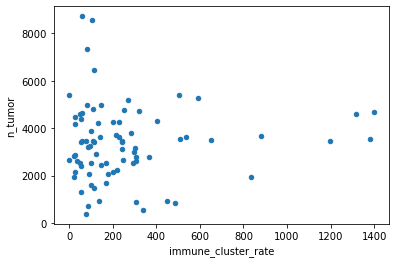

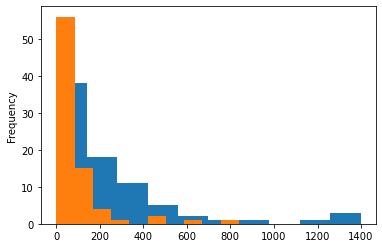

<Figure size 432x288 with 0 Axes>

In [173]:
df.plot.scatter(x='immune_cluster_rate', y='n_tumor')
plt.figure()
df["immune_cluster_rate"].plot.hist()
df["tumor_cluster_rate"].plot.hist()
(df["immune_cluster_rate"] / (df["n_immune"] + df["n_tumor"])).plot.hist(bins=100)
plt.figure()

<ipython-input-66-9baf7c0779ca>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


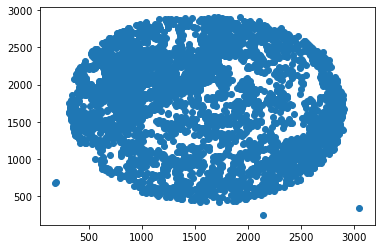

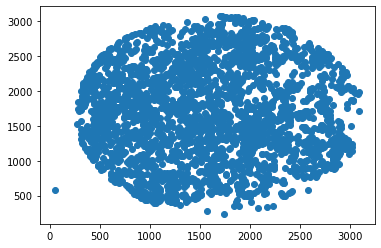

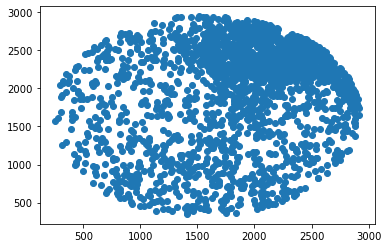

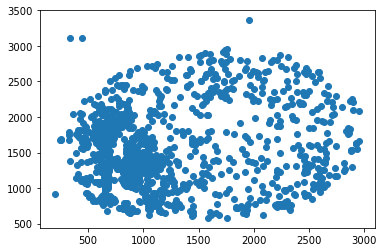

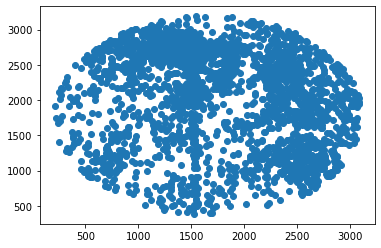

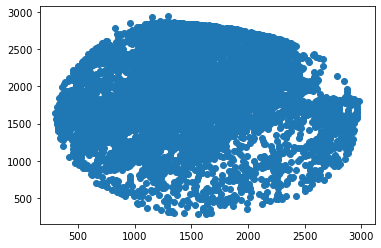

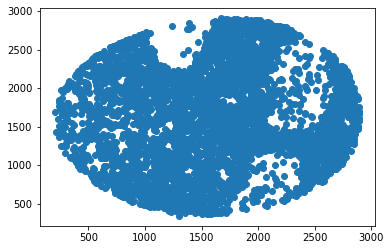

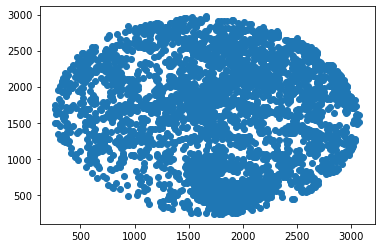

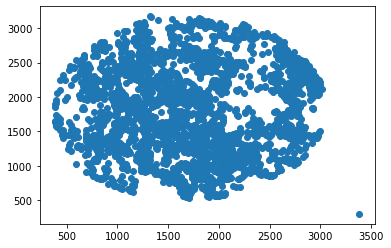

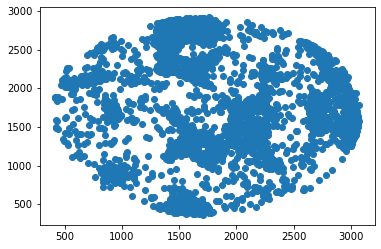

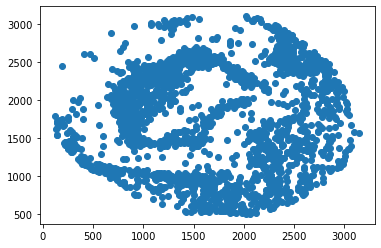

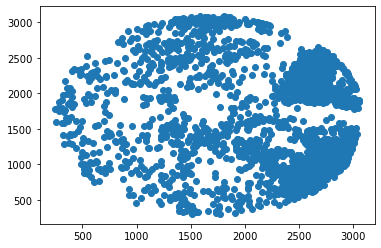

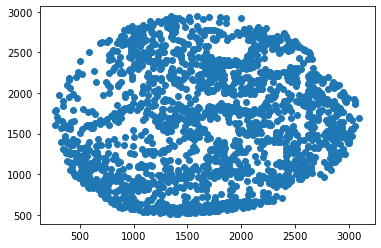

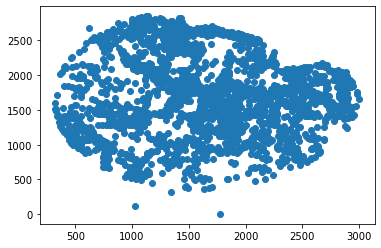

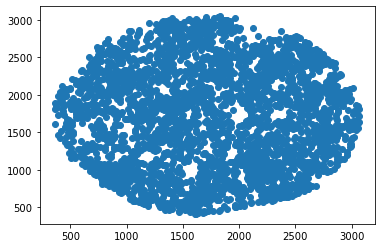

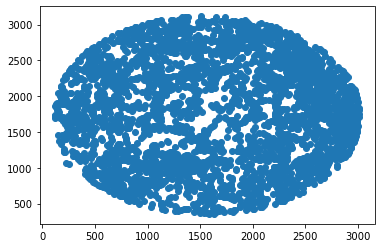

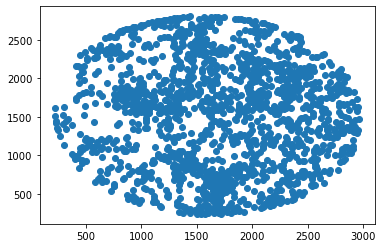

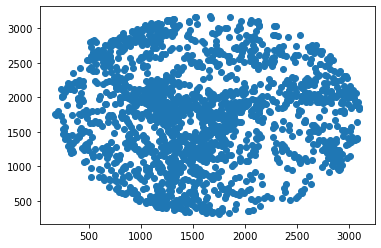

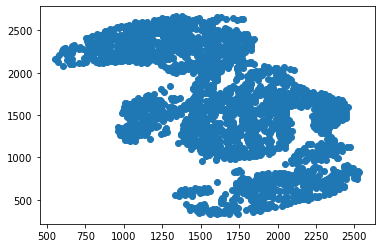

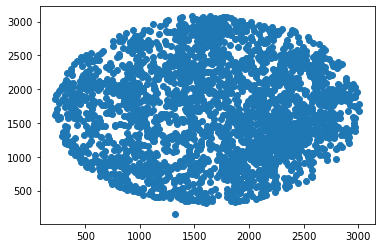

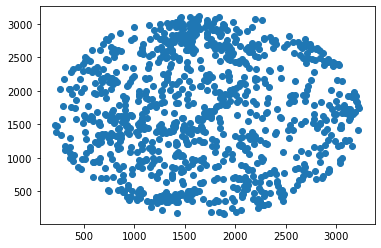

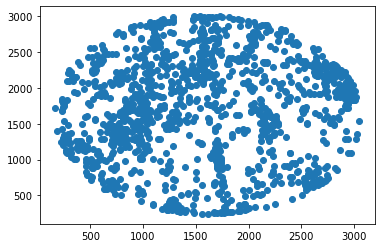

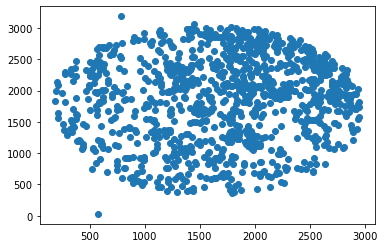

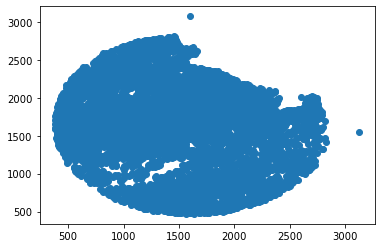

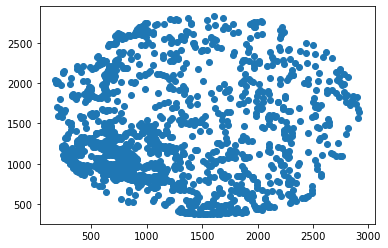

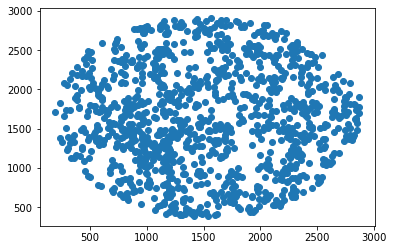

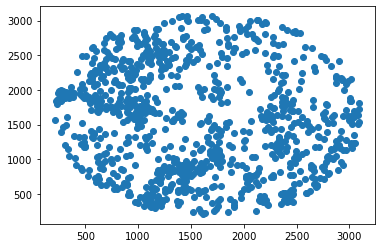

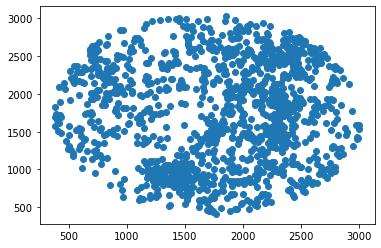

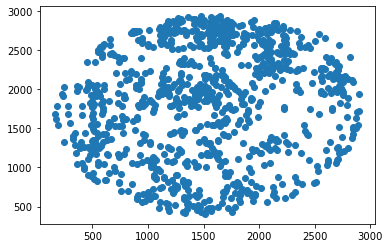

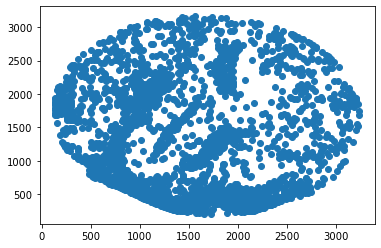

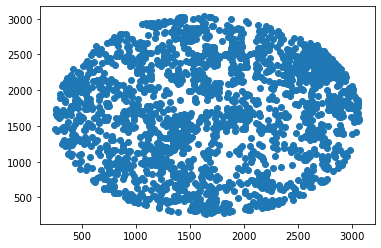

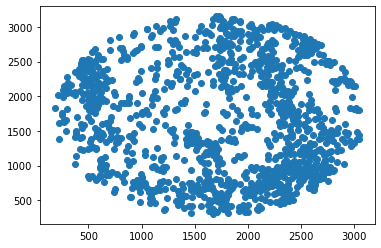

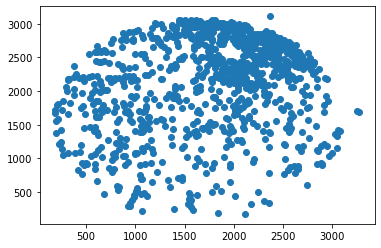

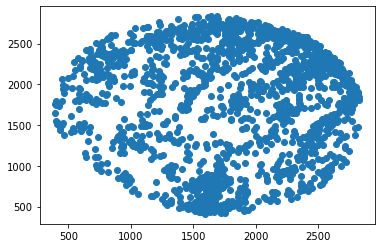

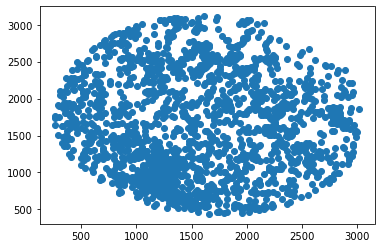

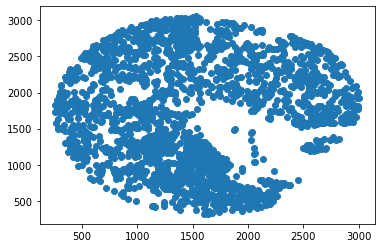

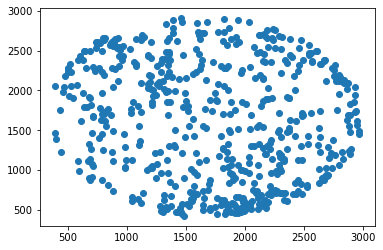

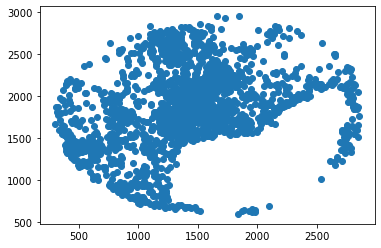

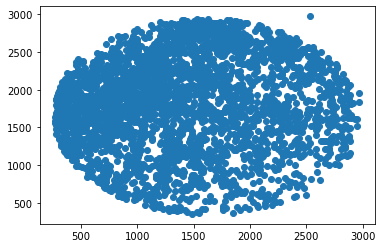

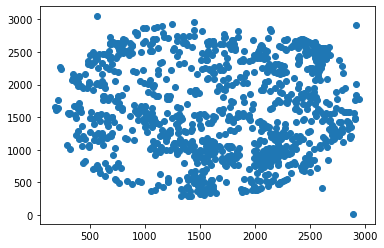

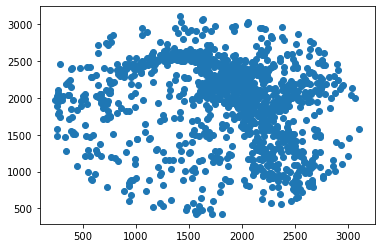

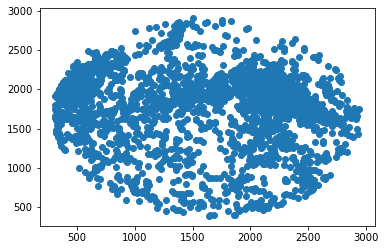

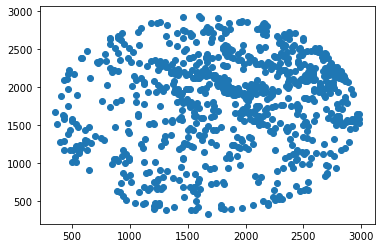

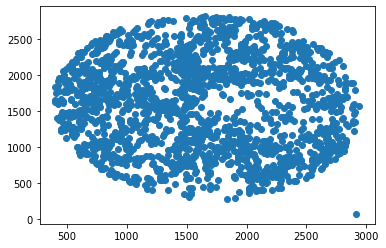

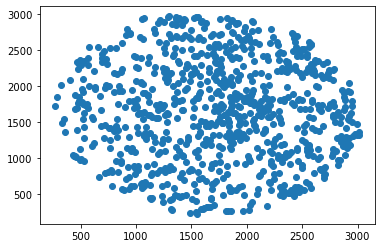

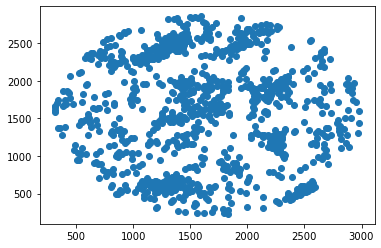

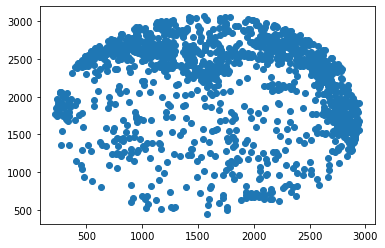

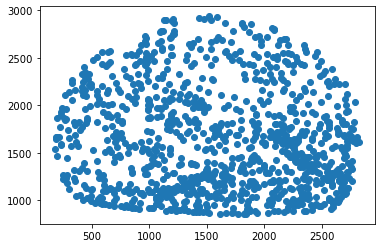

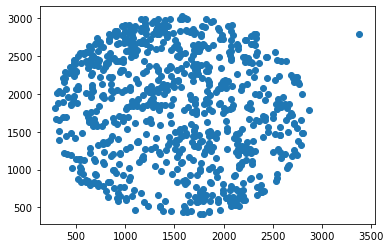

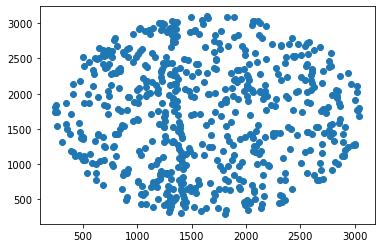

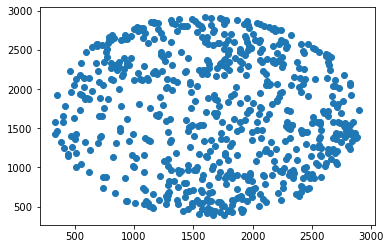

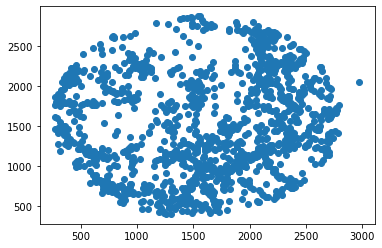

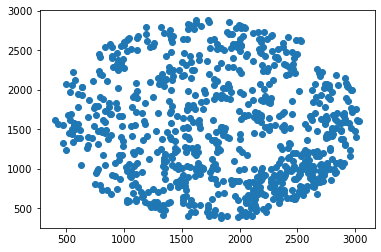

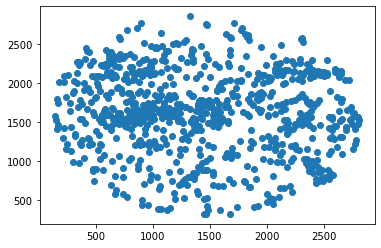

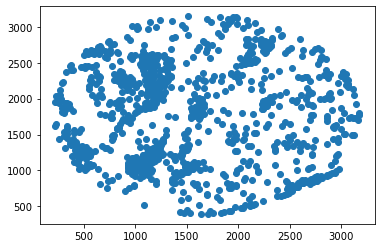

In [66]:
m = df["immune_cluster_rate"].values.mean()
from dataset import TNBC


tnbc = TNBC()
for _, row in df[df["immune_cluster_rate"] < m].sort_values('immune_cluster_rate').iterrows():
    plt.figure()
    plt.scatter(*zip(*row["immune_loc"]))

In [46]:
df["immune_loc"]

0     [(-9, -8), (-9, -7), (-9, -10), (-8, -9), (-5,...
1     [(-6, -6), (-16, -14), (-8, -15), (-4, -10), (...
2     [(-12, -9), (-23, -7), (-14, -11), (-12, -6), ...
3     [(-8, -8), (-7, -6), (-11, -7), (-6, -6), (-15...
4     [(-8, -10), (-7, -6), (-12, -11), (-7, -14), (...
                            ...                        
75    [(-8, -12), (-11, -4), (-12, -7), (-13, -9), (...
76    [(-14, -14), (-6, -7), (-9, -9), (-6, -16), (-...
77    [(-16, -12), (-10, -11), (-13, -7), (-8, -13),...
78    [(-13, -16), (-5, -10), (-7, -6), (-15, -10), ...
79    [(-14, -7), (-15, -7), (-6, -10), (-10, -9), (...
Name: immune_loc, Length: 80, dtype: object